In [1]:
# アンサンブル学習において、ご分類する確率は全学習器の過半数が誤答したとき。
# i.e n=11のときk=6以上の誤答が発生したとき、アンサンブル学習器は誤答する。

# 二項分布
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0)) # n=11のとき、k=6, 7, 8, 9, 10, 11 start=6
    probs = [comb(n_classifier, k) * (error ** k) * ((1.0 - error) ** (n_classifier - k)) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [2]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [3]:
# アンサンブル学習において、n=10, error=0.5のとき、誤答として扱うらしい
for i in range(10):
    print(ensemble_error(n_classifier=10, error=0.1 * i))
print()
for i in range(11):
    print(ensemble_error(n_classifier=11, error=0.1 * i))

0.0
0.0016349374000000007
0.03279349760000002
0.15026833260000008
0.36689674240000014
0.623046875
0.8337613824000003
0.9526510126
0.9936306176
0.9998530974

0.0
0.0002957060800000002
0.011654205440000008
0.07822479096000004
0.24650186752000006
0.5
0.7534981324800002
0.9217752090400002
0.98834579456
0.9997042939199999
1.0


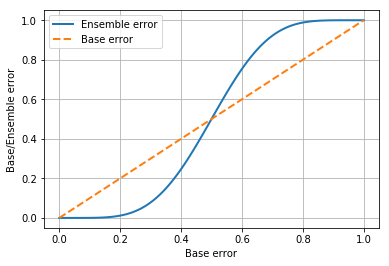

In [4]:
# アンサンブルの誤分類率 <= ベース分類器の誤分類率
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [5]:
# 重み付き多数決
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

In [6]:
# クラス確率に基づく重み付き多数決
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p=np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[0.58 0.42]


0

In [7]:
np.asarray([np.array([1, 2, 3, 4, 5]), np.array([6, 7, 8, 9, 10])])

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10]])

In [8]:
np.asarray([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])

In [9]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.labelEnc_ = LabelEncoder()
        self.labelEnc_.fit(y)
        self.classes_ = self.labelEnc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelEnc_.transform(y))
            self.classifiers_.append(fitted_clf)
            
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            # クラスの所属確率
            maj_vote = np.argmax(self.predict_proba(X), axis=1) # self.predict_proba(X): [n_samples, n_classes_prob] -> max_class
        else:
            # classlabelでの多数決
            # np.asarray([~]) : [予測ラベル（ｎ分類器から）, n_samples]
            # predictions : [n_samples, 予測ラベル（ｎ分類機から）]
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            print("predictions_shape:", predictions.shape)
            print("predictions:", predictions)
            
            # 各サンプルのクラス確率に重みをかけて足し合わせた値が最大となる列番号を配列として返す
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions)
            
        # 各サンプルに確率の最大値を与えるクラスラベルを抽出
        maj_vote = self.labelEnc_.inverse_transform(maj_vote)
        
        return maj_vote
    
    def predict_proba(self, X):
        proba = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(proba, axis=0, weights=self.weights)
        return avg_proba
    
    # 基底クラスBaseEstimatorのオーバーライド
    def get_params(self, deep=True):
        """GridSearchの実行時に分類器のパラメータを取得"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=True)
        else:
            # key : 分類器の名前_パラメータ名
            # value : パラメータ
            out = self.named_classifiers.copy()
            
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
                    
            return out

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [12]:
# ロジスティック回帰分類器、決定木分類器、k近傍法分類器のそれぞれの学習
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

In [13]:
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [15]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majority voting]


In [16]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
print(fpr)

print(tpr)

print(thresholds)


[0.  0.5 0.5 1. ]
[0.5 0.5 1.  1. ]
[0.8  0.4  0.35 0.1 ]


Logistic regression y_pred:
 [0.49730859 0.49911719 0.50081265 0.48777817 0.48720395 0.51062678
 0.51154918 0.50629477 0.50279099 0.49079115 0.49791145 0.50741544
 0.49558493 0.50864916 0.50035123 0.51057023 0.50267783 0.49386137
 0.50342213 0.4866863  0.50451465 0.49845774 0.49245785 0.50141552
 0.508734   0.49383308 0.50264954 0.49492553 0.50138723 0.50810302
 0.50448636 0.49972006 0.4996069  0.50741544 0.49664916 0.50442978
 0.49848603 0.5039401  0.50207497 0.49785487 0.50618163 0.49914548
 0.49667745 0.50922356 0.49084771 0.49311717 0.50448636 0.49842945
 0.49788316 0.49845774]
Logistic regression thresholds:
  [0.51154918 0.50810302 0.50741544 0.50451465 0.50448636 0.50207497
 0.50035123 0.49972006 0.4996069  0.49911719 0.49848603 0.49845774
 0.49664916 0.49558493 0.4866863 ]
Decision tree y_pred:
 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.95833333
 0.95833333 0.95833333 0.95833333 0.07692308 0.07692308 0.95833333
 0.07692308 0.95833333 0.95833333 0.95833333 0.9583

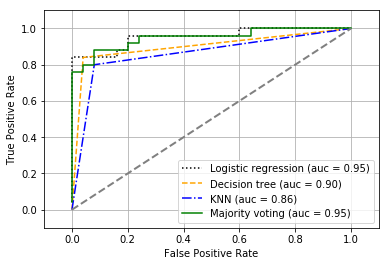

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # 陽性：1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    print('%s y_pred:\n %s' % (label, y_pred))
    
    # FPR(偽陽性率), TPR(真陽性率)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    print("%s thresholds:\n  %s" % (label, thresholds))
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [18]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
#print(xx)
#print()
#print(yy)

In [19]:
print(xx.ravel())
print()
print(yy.ravel())
print()
print(np.c_[xx.ravel(), yy.ravel()])
print()
print(np.r_[xx.ravel(), yy.ravel()])
print()
print(np.hstack((xx.ravel(), yy.ravel())))
print()
print(np.vstack((xx.ravel(), yy.ravel())))

[-3.08198191 -2.98198191 -2.88198191 ...  3.61801809  3.71801809
  3.81801809]

[-3.3441048 -3.3441048 -3.3441048 ...  3.2558952  3.2558952  3.2558952]

[[-3.08198191 -3.3441048 ]
 [-2.98198191 -3.3441048 ]
 [-2.88198191 -3.3441048 ]
 ...
 [ 3.61801809  3.2558952 ]
 [ 3.71801809  3.2558952 ]
 [ 3.81801809  3.2558952 ]]

[-3.08198191 -2.98198191 -2.88198191 ...  3.2558952   3.2558952
  3.2558952 ]

[-3.08198191 -2.98198191 -2.88198191 ...  3.2558952   3.2558952
  3.2558952 ]

[[-3.08198191 -2.98198191 -2.88198191 ...  3.61801809  3.71801809
   3.81801809]
 [-3.3441048  -3.3441048  -3.3441048  ...  3.2558952   3.2558952
   3.2558952 ]]


In [20]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])

np.vstack((a, b))

array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8]])

In [21]:
c = np.array([1, 2, 3])
d = np.array([4, 5, 6])

print( np.vstack((c, d)) )
print( np.r_[c, d] )
print( np.c_[c, d] )

[[1 2 3]
 [4 5 6]]
[1 2 3 4 5 6]
[[1 4]
 [2 5]
 [3 6]]


In [22]:
np.hstack((c, d))

array([1, 2, 3, 4, 5, 6])

In [23]:
np.hstack((a, b))

array([[1, 2, 5, 6],
       [3, 4, 7, 8]])

In [24]:
for i in product([0, 1], [0, 1]):
    print(i)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


predictions_shape: (4690, 3)
predictions: [[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [1 1 1]
 [1 1 1]
 [1 1 1]]


C:\Anaconda5.1\envs\kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


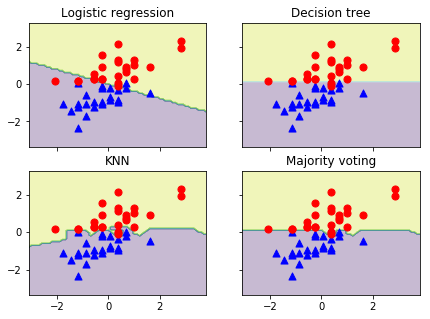

In [25]:
f, axarr = plt.subplots(nrows=2, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='red', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)

In [26]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

In [27]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
         'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [28]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r" % (grid.cv_results_['mean_test_score'][r],
                                  grid.cv_results_['std_test_score'][r] / 2.0,
                                  grid.cv_results_['params'][r]))
    

0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [29]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97
